In [553]:
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [560]:
def EDF(X):
    N = len(X)
    Y = [n/float(N) for n in range(N)]
    return(sorted(X), Y)

In [562]:
def CDF(p, minx = -5, maxx = 5, dx = .1):
    X = np.arange(minx,maxx,dx)
    Y = tf.cumsum(p(np.arange(minx,maxx,dx).reshape(-1,1)))*dx
    return(X, Y)

In [556]:
def sq_dists(Z):
    A = tf.reshape(Z, (tf.shape(Z)[0], -1))
    r = tf.reduce_sum(A*A, 1)
    r = tf.reshape(r, [-1, 1])
    sqdists = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return sqdists

def med(D):
    m = tf.contrib.distributions.percentile(D, 50)
    return m
    
def kernel(Z, h = -1):
    sqdists = sq_dists(Z)
    if h <= 0:
        medsq = med(sqdists)
        h = medsq / np.log(Z.shape.as_list()[0])
    h = tf.stop_gradient(h)
    ker = tf.exp(-sqdists/h)
    A = tf.tile(tf.expand_dims(Z, 0), (Z.shape.as_list()[0],1,1))
    T = tf.transpose(A, (1,0,2)) - A
    dker_dz = -2*tf.multiply(tf.tile(tf.expand_dims(ker, 2), (1,1,Z.shape.as_list()[1])), T)/h
    return(ker, dker_dz)

def phi_star(Z, p, h = -1):
    ker, dker = kernel(Z, h=h)
    logp = tf.log(p(X))
    dlogp = tf.gradients(logp, X)[0]
    phi_mat = tf.einsum('ij,ik->ijk', ker, dlogp) + dker
    phi_mean = tf.reduce_mean(phi_mat, 0)
    return(phi_mean)

In [577]:
p = lambda z: .5*(1/np.sqrt(2*np.pi*.5))*tf.exp(-tf.square(tf.norm(z-2, axis=1))/(2*.5)) + .5*(1/np.sqrt(2*np.pi*.5))*tf.exp(-tf.square(tf.norm(z+2, axis=1))/(2*.5))

In [581]:
n = 100
X = np.random.uniform(-5,5,n).astype('float32').reshape(n,-1)
X = tf.Variable(X)
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

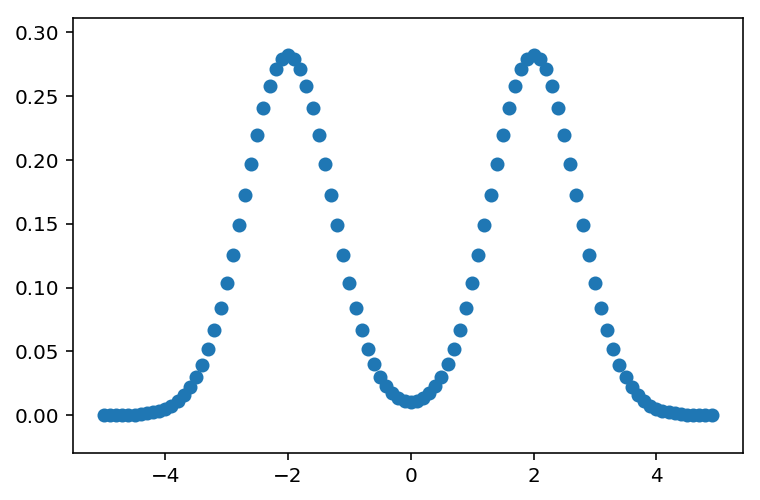

In [582]:
plt.scatter(cdf[0], sess.run(p(cdf[0].reshape(-1,1))))

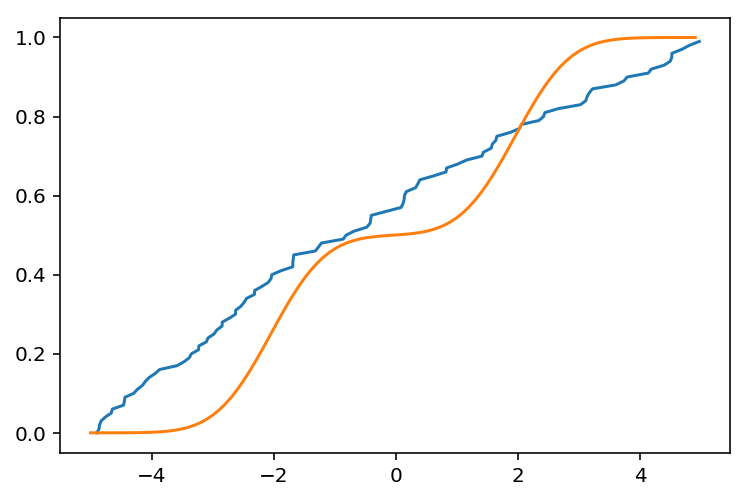

In [583]:
edf = EDF(X.eval(session=sess))
plt.plot(edf[0], edf[1])

cdf = CDF(p)
plt.plot(cdf[0], sess.run(cdf[1]))

In [593]:
Xs = []
Xnew = tf.identity(X)
for i in range(200):
    Xnew = Xnew + 1e-2*phi_star(Xnew, p)
    if i % 20 == 0:
        Xs.append(sess.run(Xnew))

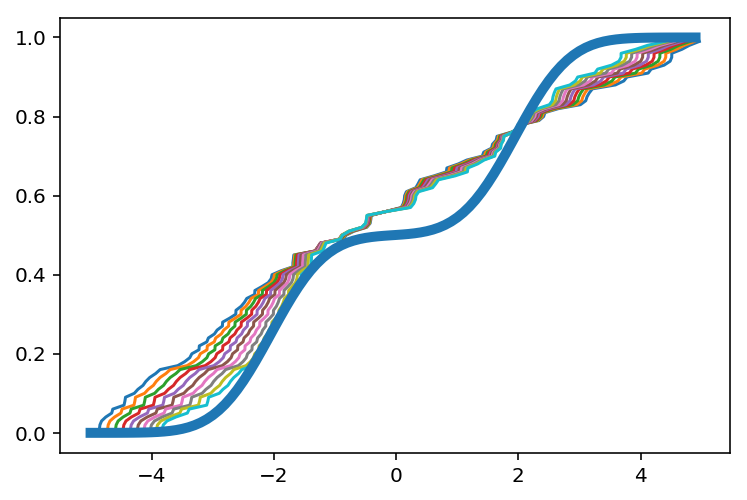

In [594]:
for x in Xs:
    edf = EDF(x)
    plt.plot(edf[0], edf[1])
cdf = CDF(p)
plt.plot(cdf[0], sess.run(cdf[1]), linewidth=5.0)

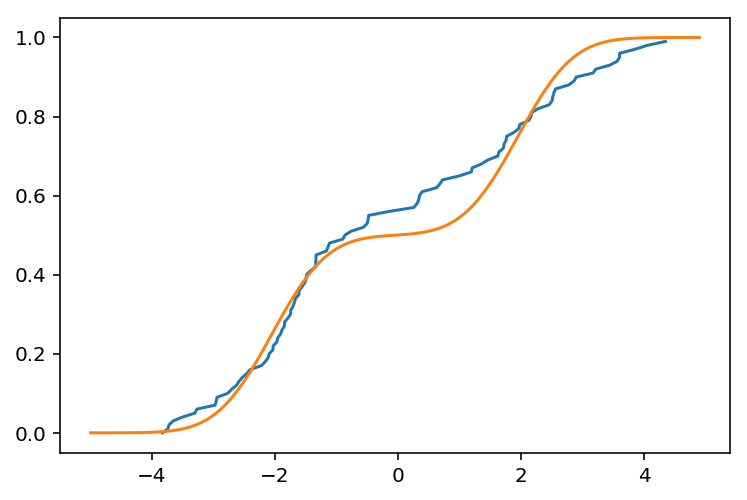

In [595]:
edf = EDF(Xnew.eval(session=sess))
plt.plot(edf[0], edf[1])
cdf = CDF(p)
plt.plot(cdf[0], sess.run(cdf[1]))

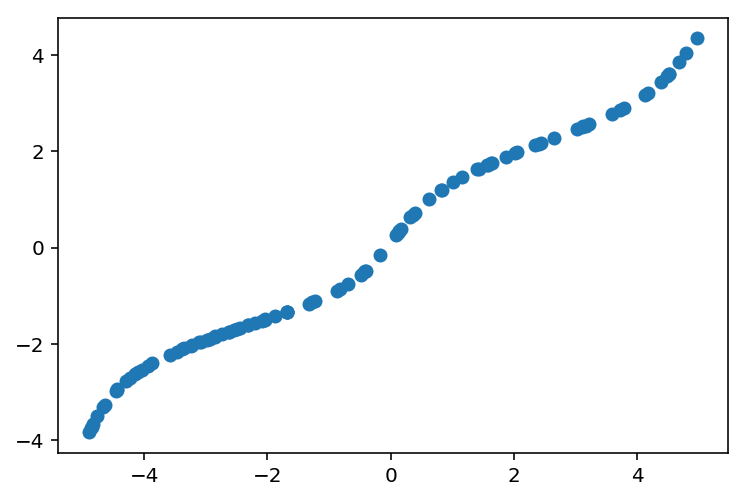

In [596]:
plt.scatter(X.eval(session=sess), Xnew.eval(session=sess))